In [1]:
import datetime as dt
import talib as ta
import numpy as np
import matplotlib.pyplot as plt
import pandas_datareader.data as pdr
import yfinance as yf
import pandas as pd
import json

In [2]:
import import_ipynb
import GoodStock

importing Jupyter notebook from GoodStock.ipynb


In [6]:
debug = False


class State:
    def __init__(self, name):
        self.name = name
    
    def on_event(self, data, day):
        pass
    
class UndefineState(State):
    def __init__(self, date):
        super().__init__('Undef')
        self.date = date if date is not None else pd.Timestamp("2000-01-01 00:00:00")

    def on_event(self, data, day): #only when on_event, the date is that true date + 1
        #cause when we are event means we are already in this stage and now we want to choose 
        #what stage should we go based on today's data
        self.date = data.index[day]
        if isRise(data, day, 0.015):
            return Rise1(self.date)
        return self
    
class Rise1(State):
    def __init__(self, date):
        super().__init__('Rise1')
        #self.limit = limit
        self.date = date if date is not None else pd.Timestamp("2000-01-01 00:00:00")
        self.days_rised = 0
    
    def on_event(self, data, day):
        self.date = data.index[day]
        self.days_rised += 1
        if debug:
            print("Rise1 on event:")
            print(self.date)
        if isRise(data, day, 0.023): #keep rising #hard code
            return Rise2(self.date)
        
        return UndefineState(self.date)

class Rise2(State):
    def __init__(self, date):
        super().__init__('Rise2')
        #self.limit = limit
        self.date = date if date is not None else pd.Timestamp("2000-01-01 00:00:00")
        self.days_rised = 0
    
    def on_event(self, data, day):
        self.date = data.index[day]
        self.days_rised += 1
        if debug:
            print("Rise2 on event:")
            print(self.date)
        if isRise(data, day, 0.032): #keep rising #hard code
            return self
        if isAdjust(data, day, 0.03, 0): #hard code
            if debug:
                print("get into adjust from Rise:")
                print(self.date)
            return Adjust(self.date) #check here right or not 
        
        return UndefineState(self.date)    
    
class Adjust(State):
    def __init__(self, date): #in what limit is consdired rise
        super().__init__('Adjust')
        #self.limit = limit
        self.date = date if date is not None else pd.Timestamp("2000-01-01 00:00:00")
        self.days_adjusted = 0
    
    def on_event(self, data, day):
        self.date = data.index[day]
        self.days_adjusted += 1
        if debug:
            print("adjust on event:")
            print(self.date)
        if self.days_adjusted > 4:
            return UndefineState(self.date)
        
        if isAdjust(data, day, 0.03, self.days_adjusted): #keep adjusting
            return self
        if isHesitate(data, day, 0.03) and self.days_adjusted >= 2: #jump to wave 
            return Hesitate(self.date)
            #return Hesitate(add_days_to_date(self.date, self.days_adjusted))
        
        return UndefineState(self.date)
        #return UndefineState(add_days_to_date(self.date, self.days_adjusted)) 

class Hesitate(State):
    def __init__(self, date):
        super().__init__('Hesitate')
        self.date = date if date is not None else pd.Timestamp("2000-01-01 00:00:00")
        self.days_hesitated = 0
    
    def on_event(self, data, day):
        self.date = data.index[day]
        self.days_hesitated += 1
        if debug:
            print("Hesitate on event:")
            print(self.date)
        if self.days_hesitated > 3:
            return MatchState(self.date)
        
        if isHesitate(data, day, 0.03): #keep hesitating
            return self
        
        return MatchState(self.date)                         
  
#class Lost(State):
#    def __init__(self, date):
#        super().__init__('Lost')  # Initialize the base class with the state name
#        self.date = date  # Store the date of the match

#    def on_event(self, data, day):
#        return UndefineState(self.date)  # Transition back to NoRiseState???           
                          
class MatchState(State):
    def __init__(self, date):
        super().__init__('Match')  # Initialize the base class with the state name
        self.date = date if date is not None else pd.Timestamp("2000-01-01 00:00:00")

    def on_event(self, data, day):
        self.date = data.index[day - 1]
        stringR = self.date.strftime('%Y/%m/%d')
        print("get a match at" + stringR)
        return UndefineState(self.date)
       

In [3]:
#help function
from datetime import datetime, timedelta

def add_days_to_date(date_str, days):
    # Parse the date string into a datetime object
    date_obj = datetime.strptime(date_str, "%Y-%m-%d")
    
    # Add the desired number of days
    new_date_obj = date_obj + timedelta(days=days)
    
    # Convert the new datetime object back to a string
    new_date_str = new_date_obj.strftime("%Y-%m-%d")
    
    return new_date_str

def get_moving_average(stock_symbol, window=20):
    # Fetch historical data
    stock_data = yf.download(stock_symbol, period="1mo", interval="1d")
    
    # Calculate the moving average
    stock_data['MA20'] = stock_data['Close'].rolling(window=window).mean()
    
    return stock_data

In [4]:
# functions needs to feel
debug = False

def isRise(data, day, limit): #day is realative day to the date frame, day = 0 means the first day in the data
    #limit is when the rise is bigger than limit, it returns true for now make it 5%
    if ((data.iloc[day]["High"] - data.iloc[day - 1]["Close"]) / data.iloc[day - 1]["Close"] >= limit) and ((data.iloc[day]["Close"] - data.iloc[day - 1]["Close"]) / data.iloc[day - 1]["Close"] >= limit * 0.6):
        return True
    
    return False

   
def isAdjust(data, day, limit, days_adjusted): #limit is smaller than limit is regard as adjust for now make it 3%
    # max min is 3% more or less than the last rise close price
    last_close_day = day - days_adjusted - 1
    if debug:
        print("last day price:" + str(data.iloc[last_close_day]["Close"]))
    if abs((data.iloc[day]["High"] - data.iloc[last_close_day]["Close"]) / data.iloc[last_close_day]["Close"]) <= limit:
        #if debug:
            #print("the percentage of change from High of this day to close of the last rise:" + (data.iloc[day]["High"] - data.iloc[last_close_day]["Close"]) / data.iloc[last_close_day]["Close"])
        if abs((data.iloc[day]["Low"] - data.iloc[last_close_day]["Close"]) / data.iloc[last_close_day]["Close"]) <= limit:
            return True 
    return False
    
def isHesitate(data, day, limit):#limit is smaller than limit is regard as adjust for now make it 3%
    # (max - min) \ min < 3%
    if abs((data.iloc[day]["Open"] - data.iloc[day]["Close"]) / data.iloc[day]["Open"]) <= limit:
        if abs((data.iloc[day]["High"] - data.iloc[day]["Close"]) / data.iloc[day]["Open"]) >= limit or abs((data.iloc[day]["High"] - data.iloc[day]["Open"]) / data.iloc[day]["Open"]) >= limit or abs((data.iloc[day]["Low"] - data.iloc[day]["Open"]) / data.iloc[day]["Open"]) >= limit or abs((data.iloc[day]["Low"] - data.iloc[day]["Close"]) / data.iloc[day]["Open"]) >= limit:
            return True

    return False
        
        
ticker_symbol = 'AAPL'
start_date = "2024-07-01"
end_date = "2024-07-12"

data = yf.download(ticker_symbol, start=start_date, end=end_date, interval='1d')

[*********************100%%**********************]  1 of 1 completed


In [26]:
# always start with Monday
test_start = "2024-03-04"
test_end = "2024-03-21"

data =  yf.download("CFG", start=test_start, end=test_end, interval='1d')
print(data.index[0])

[*********************100%%**********************]  1 of 1 completed

2024-03-04 00:00:00


In [7]:
# Example data
array1 = [0.06, 0.09, 0.05, -0.0482, 0.2, -0.15, 0.1, -0.1, 0.08]

def draw_profit(array1):
    profits = np.array(array1)

    # Clip the data to the range -0.1 to 0.1
    profits_clipped = np.clip(profits, -0.1, 0.1)

    # Step 3: Bin the Data
    profit_bins = np.round(profits_clipped * 100).astype(int)

    # Step 4: Count the Number of Stocks in Each Bin
    # Use numpy's bincount to count the occurrences of each bin, shift to start at -10
    counts = np.bincount(profit_bins + 10, minlength=21)

    # Step 5: Plot the Data
    # Create x values from -10 to 10
    x_values = np.arange(-10, 11)

    plt.bar(x_values, counts, width=0.8, align='center', color='blue', alpha=0.7)
    plt.xlabel('Profit (%)')
    plt.ylabel('Number of Stocks')
    plt.title('Number of Stocks by Profit Percentage')
    plt.xticks(x_values)  # Ensure all x values from -10 to 10 are shown
    plt.grid(True)

    # Show the plot
    plt.show()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


get a match at2024/03/19


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


get a match at2024/04/30


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


get a match at2024/03/14


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


get a match at2024/03/28
get a match at2024/05/01


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


get a match at2024/03/28


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


get a match at2024/01/25
get a match at2024/03/28
*****************************************************************
AVGO
results:
[Timestamp('2024-01-25 00:00:00'), Timestamp('2024-03-28 00:00:00')]


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


get a match at2024/02/08


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


get a match at2024/02/01
get a match at2024/05/13


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

get a match at2024/03/28


[*********************100%%**********************]  1 of 1 completed


get a match at2024/07/26


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


get a match at2024/02/14


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


get a match at2024/02/22
get a match at2024/06/17


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


get a match at2024/07/24


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


get a match at2024/01/25
get a match at2024/07/01
get a match at2024/07/19
*****************************************************************
CHTR
results:
[Timestamp('2024-07-01 00:00:00'), Timestamp('2024-07-19 00:00:00')]


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


get a match at2024/03/22


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


get a match at2024/04/29


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


get a match at2024/01/29


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


get a match at2024/06/26


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

get a match at2024/03/07


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


get a match at2024/03/12


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


get a match at2024/07/23


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


get a match at2024/05/02


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

get a match at2024/04/29
get a match at2024/05/13


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


get a match at2024/01/12


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

get a match at2024/06/04



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


get a match at2024/06/27


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


get a match at2024/04/05


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


get a match at2024/01/31


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


get a match at2024/04/29


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


get a match at2024/03/26


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


get a match at2024/05/10


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

get a match at2024/03/01


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

get a match at2024/05/02


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


get a match at2024/02/05


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

get a match at2024/06/07


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


get a match at2024/02/14


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


get a match at2024/04/16


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


get a match at2024/07/12


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


get a match at2024/06/21


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


get a match at2024/03/21


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


get a match at2024/05/02


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


get a match at2024/07/15


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


get a match at2024/03/18


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


get a match at2024/07/12


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


get a match at2024/01/25
get a match at2024/05/03


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


get a match at2024/03/28


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


get a match at2024/03/06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

get a match at2024/05/06
get a match at2024/06/13
*****************************************************************
PODD
results:
[Timestamp('2024-05-06 00:00:00'), Timestamp('2024-06-13 00:00:00')]


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


get a match at2024/07/19


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


get a match at2024/04/10


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


get a match at2024/06/04


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


get a match at2024/01/17


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


get a match at2024/05/22


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


get a match at2024/07/02


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


get a match at2024/02/22


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


get a match at2024/02/05
get a match at2024/03/06


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

get a match at2024/07/17


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


get a match at2024/01/29


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


get a match at2024/07/23


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

get a match at2024/03/08


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

get a match at2024/01/24


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


get a match at2024/02/02


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


get a match at2024/04/02


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


get a match at2024/02/02


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


there are 51 times operations from 2024-01-01 to 2024-08-01
total of the profits for selling at high: 1.2862286694220229
total of the profits for selling at close: 0.5867408654759132


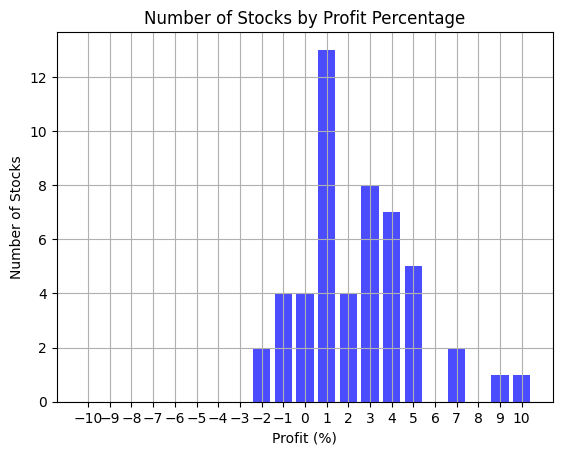

In [15]:
# main loop

# when we find the date that rises, we getinto the state machine

ticker_symbol = 'AAPL'
start_date = "2024-01-01"
end_date = "2024-08-01"


#we give you the data for today and you tell me what state do we change to after today
def find_stock_pattern(data, date, stock, profits_close, profits_high):
    state = UndefineState(date)
    results = []

    
    for day in range(len(data)): #this day is starting 0 from the date of rise
        if (day == 0): #skip the frst day because we need 0 day to compare 
            day = 1
        state = state.on_event(data, day)
        #print(state.name + " " + state.date)     
        
        if state.name == "Match":
            if GoodStock.is_ma20_going_up(stock, state.date.strftime('%Y-%m-%d')):
                #print(data.iloc[day]["Close"])
                if day + 2 < len(data):
                    profits_close.append((data.iloc[day + 2]["Close"] - data.iloc[day]["Close"]) / data.iloc[day]["Close"])
                    profits_high.append((data.iloc[day + 2]["High"] - data.iloc[day]["Close"]) / data.iloc[day]["Close"])
                    results.append(state.date)
            
                
        
    return results


# get the stocks symbols 
from yahoo_fin import stock_info as si
df1 = pd.DataFrame(si.tickers_sp500())
#df1 = pd.DataFrame( si.tickers_nasdaq() )
# df3 = pd.DataFrame( si.tickers_dow() ) 30

symbol_list = df1[0].tolist()


#compute the profit
profits_close = []
profits_high = []


for item in symbol_list:
    data =  yf.download(item, start=start_date, end=end_date, interval='1d')
    res = find_stock_pattern(data, start_date, item, profits_close, profits_high)
    
    if len(res) > 1:
        print("*****************************************************************")
        print(item)
        print("results:")
        print(res)

print("there are " + str(len(profits_high)) + " times operations from " + start_date + " to " + end_date)
print("total of the profits for selling at high: " + str(np.sum(profits_high)))
print("total of the profits for selling at close: " + str(np.sum(profits_close)))
draw_profit(profits_high)
draw_profit(profits_close)

In [ ]:
#debug version
